# Tutorial for mapping data with Tangram
by Tommaso Biancalani <biancalt@gene.com> and Ziqing Lu <luz21@gene.com>

- The notebook introduces to mapping single cell data on spatial data by using Tangram.
- The notebook uses data from mouse brain cortex, although different than those adopted in the manuscript (which need to wait May 2020 before being released).

#### Last changelog
- Review - Mar 15th by Ziqing Lu <luz21@gene.com>

***
#### Installation

- Make sure `tangram-sc` is installed via `pip install tangram-sc`.
- The Python environment needs to install the packages listed in `environment.yml`.

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

***
#### Download the data
- If you have `wget` installed, you can run the following code to automatically download and unzip the data.

In [3]:
# !mkdir -p data

!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz -O data/mop_sn_tutorial.h5ad.gz
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz -O data/slideseq_MOp_1217.h5ad.gz
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv -O data/MOp_markers.csv
!gunzip -f data/mop_sn_tutorial.h5ad.gz
!gunzip -f data/slideseq_MOp_1217.h5ad.gz

--2021-03-24 18:16:12--  https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.112, 172.217.3.208, 172.217.14.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474724402 (453M) [application/x-gzip]
Saving to: ‘data/mop_sn_tutorial.h5ad.gz’

data/mop_sn_tutoria 100%[===================>] 452.73M  81.4MB/s    in 6.3s    

2021-03-24 18:16:19 (71.6 MB/s) - ‘data/mop_sn_tutorial.h5ad.gz’ saved [474724402/474724402]

--2021-03-24 18:16:20--  https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.80, 142.251.33.112, 172.217.3.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

- If you do not have `wget` installed, manually download data from the links below:
    - snRNA-seq datasets collected from adult mouse cortex:  [10Xv3 MOp](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz).
    - For spatial data, we will use one coronal slice of [Slide-seq2 data](
https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz) (adult mouse brain; MOp area).
    - We will map them via a few hundred [marker genes](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv), found in [literature](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).
    - All datasets need to be unzipped: resulting `h5ad` and `csv` files should be placed in the `data` folder.

***
#### Load spatial data
- Spatial data need to be organized as a voxel-by-gene matrix. Here, Slide-seq data contains 9852 spatial voxels, in each of which there are 24518 genes measured.

In [4]:
path = os.path.join('data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

- The voxel coordinates are saved in the fields `obs.x` and `obs.y` which we can use to visualize the spatial ROI. Each "dot" is the center of a 10um voxel.

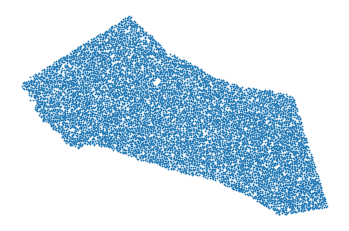

In [5]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);

***
#### Single cell data

- By single cell data, we generally mean either scRNAseq or snRNAseq.
- We start by mapping the MOp 10Xv3 dataset, which contains single nuclei collected from a posterior region of the primary motor cortex.
- They are approximately 26k profiled cells with 28k genes.

In [6]:
path = os.path.join('data','mop_sn_tutorial.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

AnnData object with n_obs × n_vars = 26431 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

- Usually, we work with data in raw count form, especially if the spatial data are in raw count form as well.
- If the data are in integer format, that probably means they are in raw count.

In [7]:
np.unique(ad_sc.X.toarray()[0, :])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  33.,
        34.,  36.,  39.,  40.,  43.,  44.,  46.,  47.,  49.,  50.,  53.,
        56.,  57.,  58.,  62.,  68.,  69.,  73.,  77.,  80.,  85.,  86.,
        98., 104., 105., 118., 121., 126., 613.], dtype=float32)

- Here, we only do some light pre-processing as library size correction (in scanpy, via `sc.pp.normalize`) to normalize the number of count within each cell to a fixed number.
- Sometimes, we apply more sophisticated pre-processing methods, for example for batch correction, although mapping works great with raw data.
- Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible and the pre-processing pipeline should be finalized to harmonize the signals.

In [8]:
sc.pp.normalize_total(ad_sc)

- It is a good idea to have annotations in the single cell data, as they will be projected on space after we map.
- In this case, cell types are annotated in the `subclass_label` field, for which we plot cell counts.
- Note that cell type proportion should be similar in the two datasets: for example, if `Meis` is a rare cell type in the snRNA-seq then it is expected to be a rare one even in the spatial data as well.

In [9]:
ad_sc.obs.subclass_label.value_counts()

L5 IT        5623
Oligo        4330
L2/3 IT      3555
L6 CT        3118
Astro        2600
Micro-PVM    1121
Pvalb         972
L6 IT         919
L5 ET         903
L5/6 NP       649
Sst           627
Vip           435
L6b           361
Endo          357
Lamp5         332
VLMC          248
Peri          187
Sncg           94
Name: subclass_label, dtype: int64

***
#### Prepare to map

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- In doing this, Tangram only looks at a subset genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types. Sometimes, we also use the entire transcriptome, or perform different mappings using different set of training genes to see how much the result change.
- For this case, we choose 253 marker genes of the MOp area which were curated [in a different study](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).

In [10]:
df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)
len(markers)

253

- We now need to prepare the datasets for mapping: the two `AnnData` structures need to be subset on the list of training genes.
- Also, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- And if data entries of a gene are all zero, this gene will be removed
- This task is performed by the helper `pp_adatas`.

In [11]:
ad_sc, ad_sp = tg.pp_adatas(ad_sc, ad_sp, genes=markers)

INFO:root:249 marker genes shared by AnnDatas.


- You'll now notice that the two datasets now contain 252 genes, but 253 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `pp_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `AnnData`s are actually ordered.

In [12]:
ad_sc

View of AnnData object with n_obs × n_vars = 26431 × 249
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'n_cells'
    layers: 'logcounts'

In [13]:
assert ad_sc.var.index.equals(ad_sp.var.index)

- At this point, it is possible to save the structures, then restart the python kernel.

In [14]:
ad_sc.write_h5ad('ad_sc_readytomap.h5ad')
ad_sp.write_h5ad('ad_sp_readytomap.h5ad')

***
#### Map

In [42]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

In [43]:
ad_sp = sc.read_h5ad('ad_sp_readytomap.h5ad')
ad_sc = sc.read_h5ad('ad_sc_readytomap.h5ad')

- We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus,which can be controlled by passing the `num_epochs` parameter. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data: higher score means better mapping
- Note that we obtained excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- If you are running Tangram with a GPU, uncomment `device=cuda:0` and comment the line `device=cpu`. On a MacBook Pro 2018, it takes ~1h to run. On a P100 GPU it should be done in a few minutes.
- For this basic mapping, we do not use regularizers. More sophisticated loss functions can be used using the Tangram library (refer to manuscript or dive into the code). For example, you can pass your `density_prior` with the hyperparameter `lambda_d` to regularize the spatial density of cells. Currently 'uniform', 'rna_count_based' and customized input array are supported for `density_prior` argument.
- We can map at cluster-level single cell data instead of cell level data (refer to manuscript or dive into the code), which is faster and requires less memory. In this notebook, we are mapping at individual cell level.

In [6]:
ad_map = tg.map_cells_to_space(
    adata_cells=ad_sc,
    adata_space=ad_sp,
#     device='cpu',
    device='cuda:0',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 249 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.103
Score: 0.802
Score: 0.818
Score: 0.822
Score: 0.824
Score: 0.825
Score: 0.826
Score: 0.826
Score: 0.827
Score: 0.827


INFO:root:Saving results..


- The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
    - The cell-by-spot matrix `X` contains the probability of cell $i$ to be in spot $j$.
    - The `obs` dataframe contains the metadata of the single cells.
    - The `var` dataframe contains the metadata of the spatial data.
    - The `uns` dictionary contains a dataframe with various information about the training genes (saved ad `train_genes_df`).
- We can now save the mapping results for post-analysis.

In [7]:
ad_map.write_h5ad('ad_map.h5ad')

***
#### Analysis

In [8]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

- We load the single cell data, the spatial data and the mapping results.
- We load the original datasets, rather than the `AnnData` pre-processed with `pp_adatas` here

In [9]:
path = os.path.join('data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)

path = os.path.join('data','mop_sn_tutorial.h5ad')
ad_sc = sc.read_h5ad(path)
sc.pp.normalize_total(ad_sc)

ad_map = sc.read_h5ad('ad_map.h5ad')
ad_map

AnnData object with n_obs × n_vars = 26431 × 9852
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

- The most common goal of mapping single cell data onto space, is to transfer cell type annotations onto space.
- This is achieved by `plot_cell_annotation`, via which we visualize spatial probability maps of the passed `obs` annotations (here, the `subclass_label` field). You can set `robust` argument to `True` and at the same time set the `perc` argument to set the range to the colormap, which would help remove outliers
- The following plots recover cortical layers of excitatory neurons and sparse patterns of glia cells. The boundaries of the cortex are neatly defined by layer 6b (cell type _L6b_) and oligodendrocytes are found concentrated into sub-cortical region, as expected.
- Yet, the _VLMC_ cell type patterns does not seem correct: _VLMC_ cells are clustered in the first cortical layer, whereas here are sparse in the ROI. This usually means that either (1) we have not used good marker genes for _VLMC_ cells in our training genes (2) the present marker genes are very sparse in the spatial data, therefore they don't bear good mapping signal.

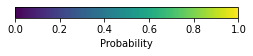

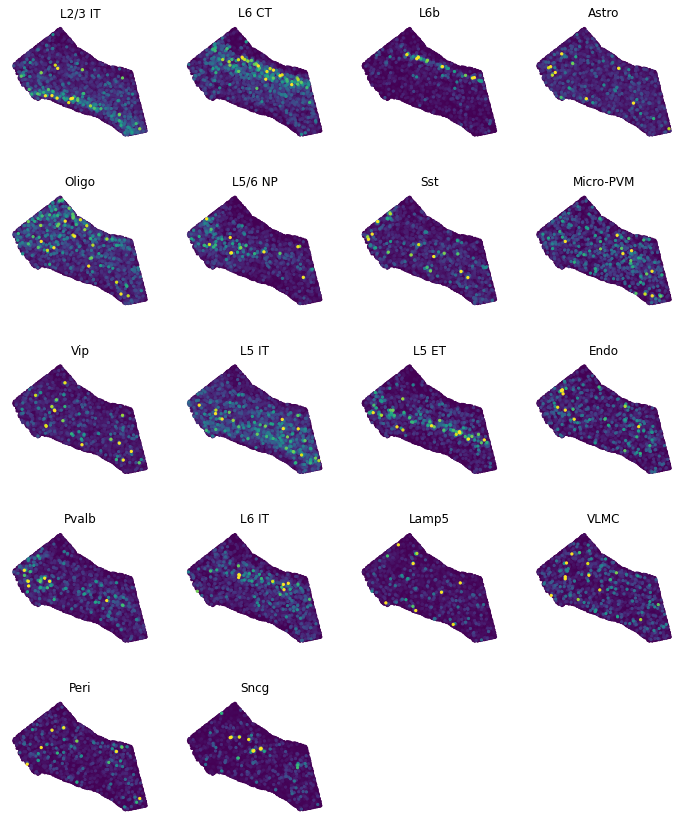

In [10]:
tg.plot_cell_annotation(ad_map, annotation='subclass_label', nrows=5, ncols=4, robust=True, perc=0.05)

- Let's try to get a deeper sense of how good this mapping is. A good helper is `plot_training_scores` which gives us four panels:
    - The first panels is a histogram of the simlarity score for each training gene. Most genes are mapped with very high similarity (> .9) although few of them have score ~.5. We would like to understand why for these genes the score is lower.
    - The second panel shows that there is a neat correlation between the training score of a gene (y-axis) and the sparsity of that gene in the snRNA-seq data (x-axis). Each dot is a training gene. The trend is that the sparser the gene the higher the score: this usually happens because very sparse gene are easier to map, as their pattern is matched by placing a few "jackpot cells" in the right spots.
    - The third panel is similar to the second one, but contains the gene sparsity of the spatial data. Spatial data are usually more sparse than single cell data, a discrepancy which is often responsible for low quality mapping.
    - In the last panel, we show the training scores as a function of the difference in sparsity between the dataset. For genes with comparable sparsity, the mapped gene expression is very similar to that in the spatial data. However, if a gene is quite sparse in one dataset (typically, the spatial data) but not in other, the mapping score is lower. This occurs as Tangram cannot properly matched the gene pattern because of inconsistent amount of dropouts between the datasets.

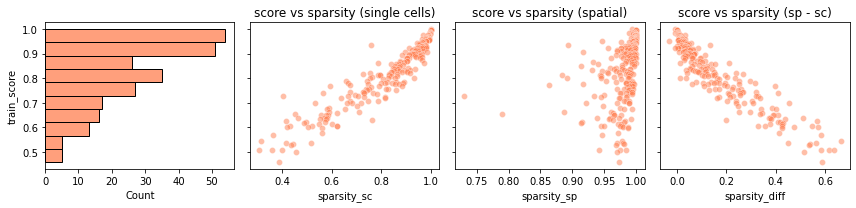

In [11]:
tg.plot_training_scores(ad_map, bins=50, alpha=.5)

- Although the above plots give us a summary of scores at single-gene level, we would need to know _which_ are the genes are mapped with low scores.
- These information can be access from the dataframe `.uns['train_genes_df']` from the mapping results; this is the dataframe used to build the four plots above.

In [12]:
ad_map.uns['train_genes_df']

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
igf2,0.999673,0.999924,0.994011,-0.005913
chodl,0.997092,0.999016,0.999086,0.000070
5031425f14rik,0.996280,0.998789,0.999594,0.000805
car3,0.995258,0.999016,0.999695,0.000679
scgn,0.994706,0.999205,0.999898,0.000693
...,...,...,...,...
5730522e02rik,0.508643,0.400401,0.984572,0.584171
ptprk,0.507275,0.357800,0.974218,0.616419
rgs6,0.505926,0.305172,0.941941,0.636769
satb2,0.500171,0.455904,0.969549,0.513645


- We want to inspect gene expression of training genes mapped with low scores, to understand the quality of mapping. 
- First, we need to generate "new spatial data" using the mapped single cell: this is done via `project_genes`.
- The function accepts as input a mapping (`adata_map`) and corresponding single cell data (`adata_sc`).
- The result is a voxel-by-gene `AnnData`, formally similar to `ad_sp`, but containing gene expression from the mapped single cell data rather than Slide-seq.

In [13]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge

AnnData object with n_obs × n_vars = 9852 × 26496
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'rna_count_based_density'
    var: 'n_cells', 'is_training'

- We now choose a few training genes mapped with low score.

In [14]:
genes = ['rgs6', 'satb2',  'cdh12']
ad_map.uns['train_genes_df'].loc[genes]

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
rgs6,0.505926,0.305172,0.941941,0.636769
satb2,0.500171,0.455904,0.969549,0.513645
cdh12,0.457910,0.384889,0.972594,0.587705


- To visualize gene patterns, we use the helper `plot_genes`. This function accepts two voxel-by-gene `AnnData`: the actual spatial data  (`adata_measured`), and a Tangram spatial prediction (`adata_predicted`). The function returns gene expression maps from the two spatial `AnnData` on the genes `genes`.
- As expected, the predited gene expression is less sparse albeit the main patterns are captured. For these genes, we trust more the mapped gene patterns, as Tangram "corrects" gene expression by aligning in space less sparse data.

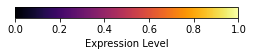

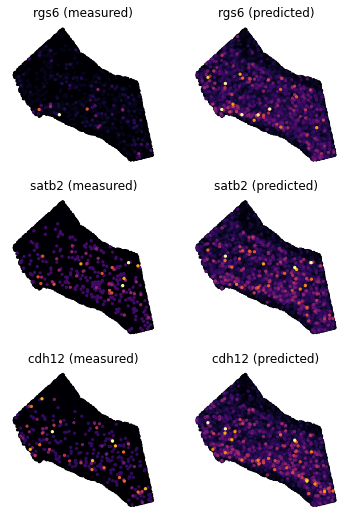

In [15]:
tg.plot_genes(genes, adata_measured=ad_sp, adata_predicted=ad_ge, robust=True, perc=0.02)

- An even stronger example is found in genes that are not detected in the spatial data, but are detected in the single cell data. They are removed before training with `pp_adatas` function. But tangram could still generate insight on how the spatial patterns look like.

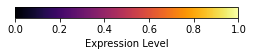

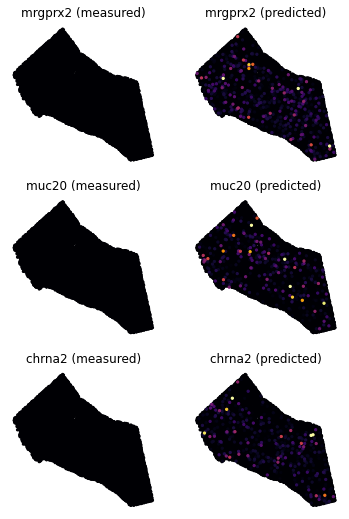

In [16]:
genes=['mrgprx2', 'muc20', 'chrna2']
tg.plot_genes(genes, adata_measured=ad_sp, adata_predicted=ad_ge, robust=True, perc=0.02)

- So far, we only inspected genes used to align the data (training genes), but the mapped single cell data, `ad_ge` contains the whole transcriptome. That includes 27k test genes.

In [17]:
(ad_ge.var.is_training == False).sum()

26247

- We can use `plot_genes` to inspect gene expression of non training genes. This is an essential step as prediction of gene expression is the how we validate mapping.
- Before doing that, it is convenient to compute the similarity scores of all genes, which can be done by `compare_spatial_geneexp`. This function accepts two spatial `AnnData`s (_ie_ voxel-by-gene), and returns a dataframe with simlarity scores for all genes. Training genes are flagged by the Boolean field `is_training`.

In [20]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, ad_sp, ad_sc)
df_all_genes

INFO:root:18000 marker genes shared by AnnDatas.
INFO:root:18000 marker genes shared by AnnDatas.


,score,is_training,sparsity_sp,sparsity_sc,sparsity_diff
igf2,9.996730e-01,True,0.994011,0.999924,-0.005913
chodl,9.970921e-01,True,0.999086,0.999016,0.000070
5031425f14rik,9.962804e-01,True,0.999594,0.998789,0.000805
car3,9.952583e-01,True,0.999695,0.999016,0.000679
scgn,9.947060e-01,True,0.999898,0.999205,0.000693
...,...,...,...,...,...
2310007b03rik,3.918572e-08,False,0.999898,0.999962,-0.000064
cst12,3.442172e-08,False,0.999898,0.999962,-0.000064
gm21317,3.052379e-08,False,0.999898,0.999962,-0.000064
cd69,8.393085e-09,False,0.999898,0.999962,-0.000064


- The plot below give us a summary of scores at single-gene level for test genes

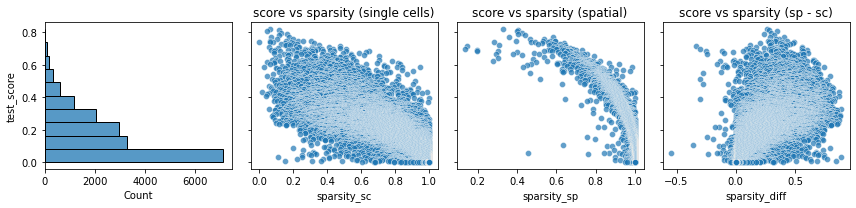

In [23]:
tg.plot_test_scores(df_all_genes)

- Let's plot the scores of the test genes and see how they compare to the training genes. Following the strategy in the previous plots, we visualize the scores as a function of the sparsity of the spatial data.
- (We have not wrapped this call into a function yet).

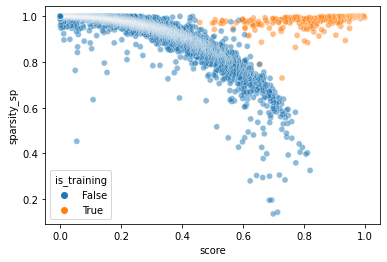

In [24]:
import seaborn as sns
sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);

- Again, sparser genes in the spatial data are predicted with low scores, which is due to the presence of dropouts in the spatial data.
- Let's choose a few test genes with varied scores and compared predictions vs measured gene expression.

In [25]:
genes = ['snap25', 'atp1b1', 'atp1a3', 'ctgf', 'nefh', 'aak1', 'fa2h', ]
df_all_genes.loc[genes]

,score,is_training,sparsity_sp,sparsity_sc,sparsity_diff
snap25,0.811524,False,0.402253,0.120048,0.282205
atp1b1,0.772142,False,0.579984,0.175778,0.404205
atp1a3,0.695145,False,0.658343,0.319587,0.338757
ctgf,0.586050,False,0.981628,0.948243,0.033386
nefh,0.502520,False,0.909156,0.916083,-0.006928
aak1,0.488882,False,0.868047,0.179713,0.688334
fa2h,0.346466,False,0.972493,0.860845,0.111648


- We can use again `plot_genes` to visualize gene patterns.
- Interestingly, the agreement for genes `Atp1b1` or `Apt1a3`, seems less good than that for `Ctgf` and `Nefh`, despite the scores are higher for the former genes. This is because even though the latter gene patterns are localized correctly, their expression values are not so well correlated (for instance, in `Ctgf` the "bright yellow spot" is in different part of layer 6b). In contrast, for `Atpb1` the gene expression pattern is largely recover, even though the overall gene expression in the spatial data is more dim.

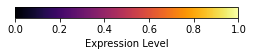

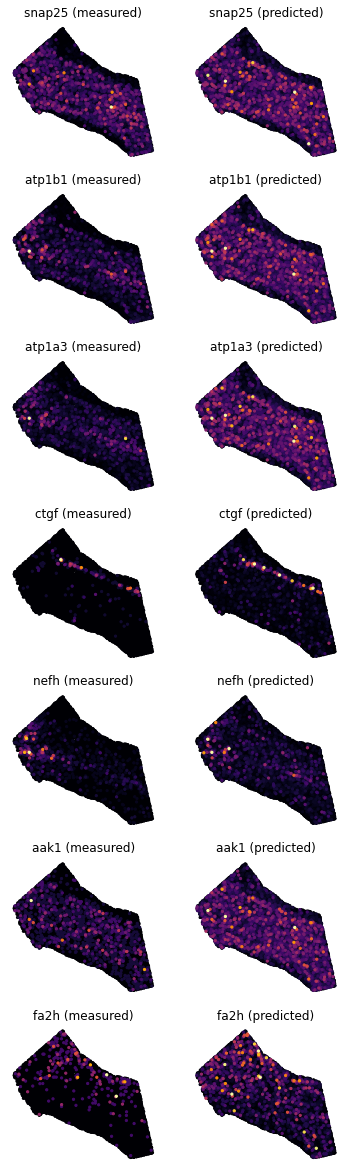

In [26]:
tg.plot_genes(genes, adata_measured=ad_sp, adata_predicted=ad_ge, robust=True, perc=0.02)

***
#### Leave-One-Out Cross Validation (LOOCV)

- If number of genes is small, Leave-One-Out cross validation (LOOCV) is supported in Tangram to evaluate mapping performance. 
- LOOCV supported by Tangram:
    - Assume the number of genes we have in the dataset is N. 
    - LOOCV would iterate over and map on the genes dataset N times.
    - Each time it hold out one gene as test gene (1 test gene) and trains on the rest of all genes (N-1 training genes).
    - After all trainings are done, average test/train score will be computed to evaluate the mapping performance.
- Assume all genes we have is the training genes in the example above. Here we demo the LOOCV mapping at cluster level. 

In [27]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

In [28]:
ad_sp = sc.read_h5ad('ad_sp_readytomap.h5ad')
ad_sc = sc.read_h5ad('ad_sc_readytomap.h5ad')

In [29]:
params = {
        'CLUSTER_LABEL': 'subclass_label',
        'WEIGHTING': True,
        'LAMBDA_D': 0,
        'LAMBDA_G1': 1,
        'LAMBDA_G2': 0,
        'LAMBDA_R': 0
    }

cv_dict, ad_ge_cv = tg.cross_val(ad_sc, 
                                 ad_sp, 
                                 device='cuda:0', 
                                 learning_rate=0.1, 
                                 num_epochs=1000,
                                 cluster_label=params['CLUSTER_LABEL'],
                                 scale=params['WEIGHTING'],
                                 lambda_d=params['LAMBDA_D'],
                                 lambda_g1=params['LAMBDA_G1'],
                                 lambda_g2=params['LAMBDA_G2'],
                                 lambda_r=params['LAMBDA_R'],
                                 return_gene_pred=True,
                                 verbose=False,
                                 )

cv avg test score 0.210
cv avg train score 0.336


* `cross_val` function will return `cv_dict` and `ad_ge_cv` under `LOOCV` mode. `cv_dict` contains the average score for cross validation and `ad_ge_cv` stores the predicted expression value for each gene.


In [30]:
cv_dict

{'mode': 'loo',
 'weighting': True,
 'lambda_d': 0,
 'lambda_g1': 1,
 'lambda_g2': 0,
 'avg_test_score': 0.2099753954234144,
 'avg_train_score': 0.3363018179514322}

In [31]:
ad_ge_cv

AnnData object with n_obs × n_vars = 9852 × 249
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'rna_count_based_density'
    var: 'test_score'

In [32]:
ad_ge_cv.write_h5ad('ad_ge_cv_cluster.h5ad')

* We can use `plot_test_scores` to display an overview of the cross validation test scores of each gene vs. sparsity. Here `adata_to_cluster_expression` function is called first to aggregate single cell data at cluster level as we ran mapping at cluster level.

In [33]:
ad_ge_cv = sc.read_h5ad('ad_ge_cv_cluster.h5ad')

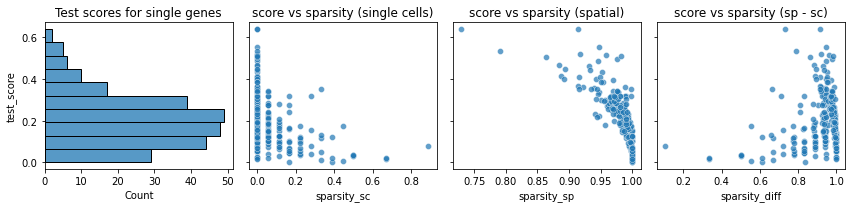

In [34]:
ad_sc = tg.adata_to_cluster_expression(ad_sc, cluster_label='subclass_label', scale=True, add_density=False);
tg.plot_cv_test_scores(ad_sc, ad_sp, ad_ge_cv.var, bins='auto', alpha=.7)

- Now, let's compare a few genes between their ground truth and cross-validation predicted spatial pattern by calling the function `plot_genes`

In [35]:
ad_ge_cv.var.sort_values(by='test_score', ascending=False)

,test_score
gad1,0.640233
slc17a7,0.640059
gad2,0.553102
grm8,0.534862
pvalb,0.519541
...,...
car3,0.014088
prok2,0.010682
scgn,0.005579
teddm3,0.001114


In [36]:
ranked_genes = list(ad_ge_cv.var.sort_values(by='test_score', ascending=False).index.values)
top_genes = ranked_genes[:3]
bottom_genes = ranked_genes[-3:]

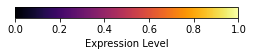

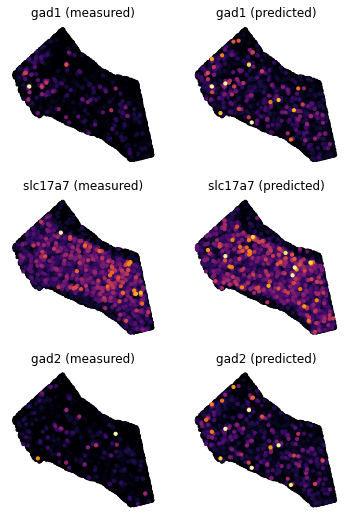

In [37]:
tg.plot_genes(genes=top_genes, adata_measured=ad_sp, adata_predicted=ad_ge_cv, s=10, robust=True, perc=0.02)

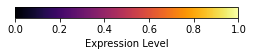

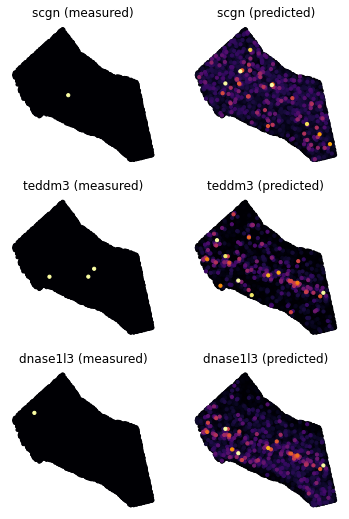

In [38]:
tg.plot_genes(genes=bottom_genes, adata_measured=ad_sp, adata_predicted=ad_ge_cv, s=10, robust=True, perc=0.02)